In [2]:
# csv文件数据之间是以','分割，unpack是可选参数，默认为False，表示不转置所读取的数据矩阵
    # skiprows=1 表示跳过第一行，,usecols=(1,2,3,4,5)表示读取列数，不读取第0列
import json
# count
with open('EEG_analysis/psd.json') as f:
    psd = json.load(f)
    
import pandas as pd
label_df = pd.read_csv('cut_data/label.csv','\t',usecols=(1,2,3,4,5,6,7))

In [5]:
# for preference
import numpy as np

print(label_df['rating'].value_counts())
preference = list(label_df['rating'])
a_mean = np.mean(preference)
a_var = np.var(preference)
a_std = np.std(preference,ddof=1)
print(a_mean,a_var,a_std)

label={}
for i in range(len(label_df)):
    path = label_df['path'][i]
    label[path]=label_df['rating'][i]

3    112
4     77
2     62
1     35
5     33
Name: rating, dtype: int64
3.0344827586206895 1.2872121932764022 1.1363362312107175


(97, 25)
(112, 25)
(110, 25)
theta
0.843 

0.724 

0.653 

0.909 

0.819 



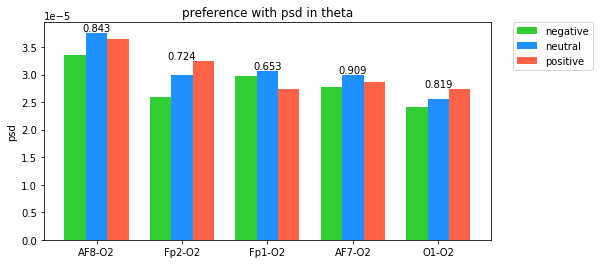

alpha
0.28 

0.922 

0.635 

0.324 

0.564 



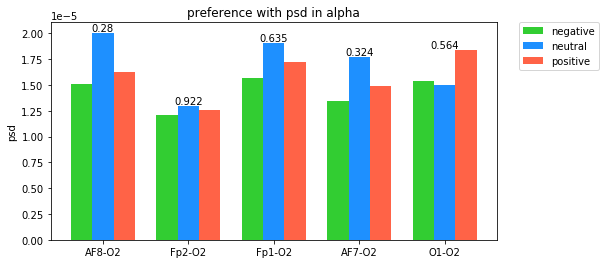

beta
0.555 

0.67 

0.876 

0.646 

0.758 



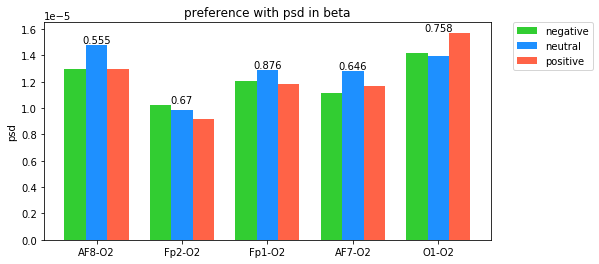

gamma
0.241 

0.166 

0.69 

0.654 

0.925 



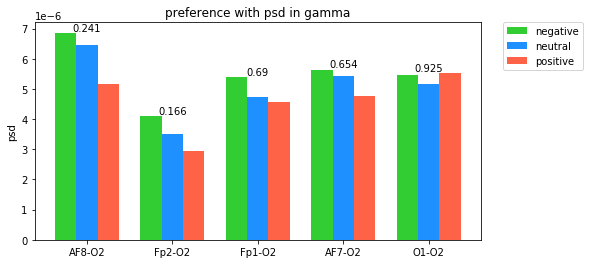

all
0.253 

0.113 

0.016 

0.423 

0.382 



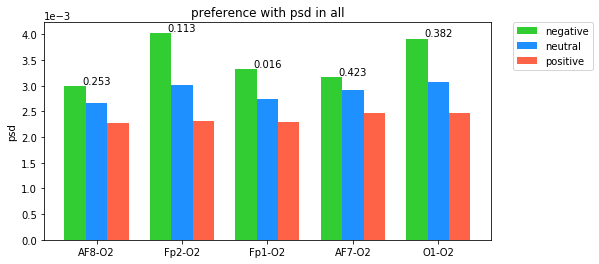

In [40]:
# for preference in 3 class：mean & ANOVA test
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
def preference_f():
    list_ne = []
    list_nu = []
    list_po = []
    for path in list(label.keys()):
        if label[path] < 3:
            list_ne.append(psd[path])
        elif label[path] == 3:
            list_nu.append(psd[path])
        else:
            list_po.append(psd[path])
    data_ne = np.array(list_ne)
    print(data_ne.shape)
    data_nu = np.array(list_nu)
    print(data_nu.shape)
    data_po = np.array(list_po)
    print(data_po.shape)

    label_name = ['theta', 'alpha', 'beta', 'gamma', 'all']

    for i in range(5):
        plt.figure(figsize=(8,4))
        print(label_name[i])

        channel = ['AF8-O2', 'Fp2-O2', 'Fp1-O2', 'AF7-O2', 'O1-O2']
        x = np.arange(len(channel))  # x轴刻度标签位置
        width = 0.25  # 柱子的宽度

        avg_po = []
        avg_nu = []
        avg_ne = []
        text = []

        for j in range(5):
            avg_po.append(np.mean(data_po[:, i+j*5]))
            avg_nu.append(np.mean(data_nu[:, i+j*5]))
            avg_ne.append(np.mean(data_ne[:, i+j*5]))
            pvalue = str(round(f_oneway(data_po[:, i+j*5],data_nu[:, i+j*5], data_ne[:, i+j*5]).pvalue, 3))
            text.append(pvalue)
            print(pvalue, '\n')

        plt.bar(x - width, avg_ne, width, label='negative',color='limegreen')
        plt.bar(x, avg_nu, width, label='neutral',color='dodgerblue')
        plt.bar(x + width, avg_po, width, label='positive',color='tomato')

        y = np.zeros((5))
        for j in range(5):
            y[j] = avg_po[j]
            if avg_nu[j] > y[j]:
                y[j] = avg_nu[j]
            if avg_ne[j] > y[j]:
                y[j] = avg_ne[j]

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

        plt.text(x[0], y[0], text[0], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
        plt.text(x[1], y[1], text[1], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
        plt.text(x[2], y[2], text[2], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
        plt.text(x[3], y[3], text[3], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
        plt.text(x[4], y[4], text[4], fontsize=10, verticalalignment="bottom", horizontalalignment="center")

        plt.ylabel('psd')
        plt.title('preference with psd in ' + label_name[i])
        plt.xticks(x, channel)
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

        plt.savefig('EEG_analysis/preference_mean' + label_name[i] + '.png')
        plt.show()
preference_f()

In [30]:
# preference AI
# label_name = ['theta', 'alpha', 'beta', 'gamma', 'all']
#channel = ['AF8-O2'(0-4), 'Fp2-O2'(5-9), 'Fp1-O2'(10-14), 'AF7-O2'(15-19), 'O1-O2'(20-24)]
ne=np.zeros((10,len(psd))) # AF*5,Fp*5
nu=np.zeros((10,len(psd)))
po=np.zeros((10,len(psd)))
af_count = np.zeros((5,3))
fp_count = np.zeros((5,3))

for j in range(len(psd)):
    path = list(psd.keys())[j]
    psd_list = psd[path]
    preference = label[path]
    for i in range(5):
        af_num = psd_list[i+15]/(psd_list[i]+psd_list[i+15])
        fp_num = psd_list[i+5]/(psd_list[i+5]+psd_list[i+10])
    
        if af_num>0.5:
            if preference < 3:
                af_count[i][0]+=1
                ne[i,j]=af_num
            elif preference == 3:
                af_count[i][1]+=1
                nu[i,j]=af_num
            else:
                af_count[i][2]+=1
                po[i,j]=af_num
        if fp_num>0.5:
            if preference < 3:
                fp_count[i][0]+=1
                ne[5+i,j]=fp_num
            elif preference == 3:
                fp_count[i][1]+=1
                nu[5+i,j]=fp_num
            else:
                fp_count[i][2]+=1
                po[5+i,j]=fp_num

all_count = [87,110,112]
print(all_count)
print(af_count)
print(fp_count)

from scipy.stats import f_oneway

for i in range(10):
    pvalue = round(f_oneway(po[i,:],nu[i,:], ne[i,:]).pvalue, 3)
    print(pvalue)


[87, 110, 112]
[[33. 25. 32.]
 [55. 51. 64.]
 [39. 37. 39.]
 [38. 43. 54.]
 [45. 55. 54.]]
[[37. 41. 42.]
 [26. 29. 30.]
 [30. 38. 47.]
 [52. 53. 55.]
 [35. 47. 48.]]
0.48
0.275
0.867
0.127
0.477
0.716
0.756
0.132
0.907
0.215


(97, 25)
(112, 25)
(110, 25)
theta
0.843 

0.724 

0.653 

0.909 

0.819 



/home/hzy/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


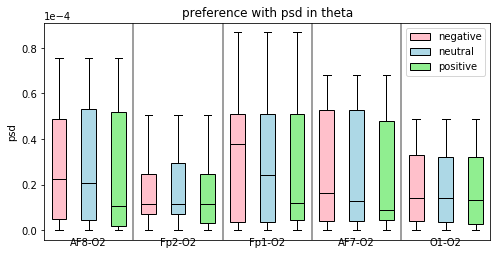

alpha
0.28 

0.922 

0.635 

0.324 

0.564 



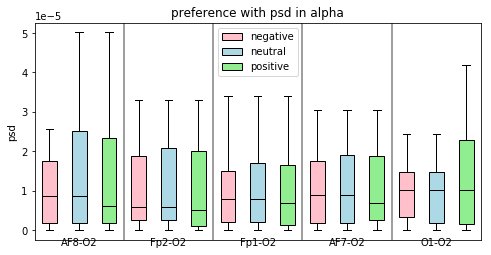

beta
0.555 

0.67 

0.876 

0.646 

0.758 



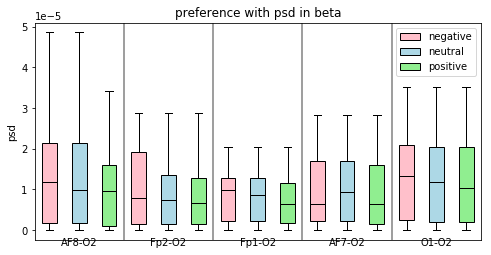

gamma
0.241 

0.166 

0.69 

0.654 

0.925 



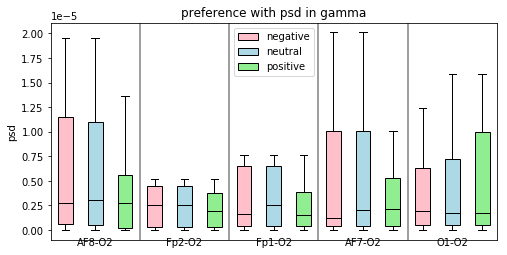

all
0.253 

0.113 

0.016 

0.423 

0.382 



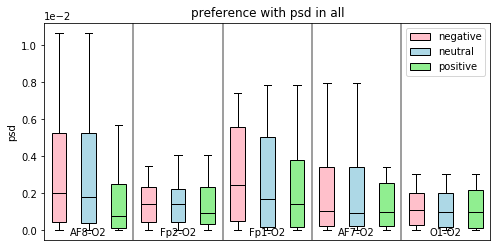

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
def preference_box():
    list_ne = []
    list_nu = []
    list_po = []
    for path in list(label.keys()):
        if label[path] < 3:
            list_ne.append(psd[path])
        elif label[path] == 3:
            list_nu.append(psd[path])
        else:
            list_po.append(psd[path])
    data_ne = np.array(list_ne)
    print(data_ne.shape)
    data_nu = np.array(list_nu)
    print(data_nu.shape)
    data_po = np.array(list_po)
    print(data_po.shape)

    label_name = ['theta', 'alpha', 'beta', 'gamma', 'all']

    for i in range(5):
        plt.figure(figsize=(8,4))
        print(label_name[i])

        channel = ['AF8-O2', 'Fp2-O2', 'Fp1-O2', 'AF7-O2', 'O1-O2']
        x = np.arange(len(channel))  # x轴刻度标签位置
        width = 0.25  # 柱子的宽度

        avg_po = []
        avg_nu = []
        avg_ne = []
        text = []

        for j in range(5):
            pvalue = str(round(f_oneway(data_po[:, i+j*5],data_nu[:, i+j*5], data_ne[:, i+j*5]).pvalue, 3))
            text.append(pvalue)
            print(pvalue, '\n')

        bplot = plt.boxplot([data_ne[:, i], data_nu[:, i], data_po[:, i],
                             data_ne[:, i+5], data_nu[:, i+5], data_po[:, i+5],
                             data_ne[:, i+10], data_nu[:, i+10], data_po[:, i+10],
                             data_ne[:, i+15], data_nu[:, i+15], data_po[:, i+15],
                             data_ne[:, i+20], data_nu[:, i+20], data_po[:, i+20]],
                            medianprops={'color': 'black'}, patch_artist=True, showfliers=False)
        colors = ['pink', 'lightblue', 'lightgreen',
                  'pink', 'lightblue', 'lightgreen',
                  'pink', 'lightblue', 'lightgreen',
                  'pink', 'lightblue', 'lightgreen',
                  'pink', 'lightblue', 'lightgreen']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        plt.legend(bplot['boxes'][:5], ['negative', 'neutral','positive'])

        plt.axvline(3.5, color='grey')
        plt.axvline(6.5, color='grey')
        plt.axvline(9.5, color='grey')
        plt.axvline(12.5, color='grey')
        ax = plt.gca()
        if i == 4:
            plt.text(0.1, 0.01, 'AF8-O2', fontsize=10, verticalalignment="bottom", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.3, 0.01, 'Fp2-O2', fontsize=10, verticalalignment="bottom", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.5, 0.01, 'Fp1-O2', fontsize=10, verticalalignment="bottom", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.7, 0.01, 'AF7-O2', fontsize=10, verticalalignment="bottom", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.9, 0.01, 'O1-O2', fontsize=10, verticalalignment="bottom", horizontalalignment="center", transform=ax.transAxes)
        else:
            plt.text(0.1, 0.01, 'AF8-O2', fontsize=10, verticalalignment="top", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.3, 0.01, 'Fp2-O2', fontsize=10, verticalalignment="top", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.5, 0.01, 'Fp1-O2', fontsize=10, verticalalignment="top", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.7, 0.01, 'AF7-O2', fontsize=10, verticalalignment="top", horizontalalignment="center", transform=ax.transAxes)
            plt.text(0.9, 0.01, 'O1-O2', fontsize=10, verticalalignment="top", horizontalalignment="center", transform=ax.transAxes)

        plt.xticks([])
        plt.title('preference with psd in ' + label_name[i])
        plt.ylabel('psd')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.savefig('EEG_analysis/preference_box' + label_name[i] + '.png')
        plt.show()

preference_box()


In [45]:
# for mood
import numpy as np

valence = list(label_df['mood_valence'])
a_mean = np.mean(valence)
a_var = np.var(valence)
a_std = np.std(valence,ddof=1)
print('valence',a_mean,a_var,a_std)

arousal = list(label_df['mood_arousal'])
a_mean = np.mean(arousal)
a_var = np.var(arousal)
a_std = np.std(arousal,ddof=1)
print('arousal',a_mean,a_var,a_std)


mood={'valence':{},'arousal':{}}

for i in range(len(label_df)):
    path = label_df['path'][i]
    mood['valence'][path]=label_df['mood_valence'][i]
    mood['arousal'][path]=label_df['mood_arousal'][i]

'''# mood归一化
mood_sub = {'val':{},'aro':{}} #sub:[]
for path in mood['val']:
    sub = path.split('_')[0]
    if sub not in mood_sub['val']:
        mood_sub['val'][sub]=[]
        mood_sub['aro'][sub]=[]
    val_ele = {mood['val'][path]:path}
    aro_ele = {mood['aro'][path]:path}
    mood_sub['val'][sub].append(val_ele)
    mood_sub['aro'][sub].append(aro_ele)

mood_nor={'val':{},'aro':{}}
for sub in mood_sub['val']:
    val = list(mood_sub['val'][sub].keys())
    M = val.max()
    m = val.min()
    for i in range(len(val):
        val[i] = (val[i]-m)/(M-m)'''
#mood 被试归一化，然后看mood数值和psd相关性

valence 0.5283887147335423 0.008558099684554985 0.09265533955317395
arousal 0.45613479623824454 0.044970687159127755 0.21239610263454728


"# mood归一化\nmood_sub = {'val':{},'aro':{}} #sub:[]\nfor path in mood['val']:\n    sub = path.split('_')[0]\n    if sub not in mood_sub['val']:\n        mood_sub['val'][sub]=[]\n        mood_sub['aro'][sub]=[]\n    val_ele = {mood['val'][path]:path}\n    aro_ele = {mood['aro'][path]:path}\n    mood_sub['val'][sub].append(val_ele)\n    mood_sub['aro'][sub].append(aro_ele)\n\nmood_nor={'val':{},'aro':{}}\nfor sub in mood_sub['val']:\n    val = list(mood_sub['val'][sub].keys())\n    M = val.max()\n    m = val.min()\n    for i in range(len(val):\n        val[i] = (val[i]-m)/(M-m)"

valence
(109, 25)
(104, 25)
(106, 25)
theta
0.091 

0.133 

0.035 

0.1 

0.26 



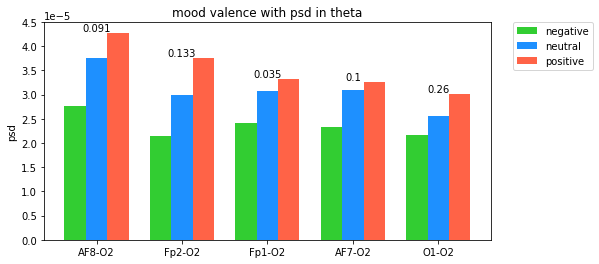

alpha
0.038 

0.041 

0.09 

0.048 

0.075 



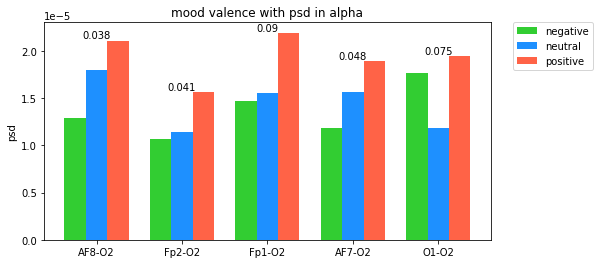

beta
0.204 

0.318 

0.361 

0.309 

0.356 



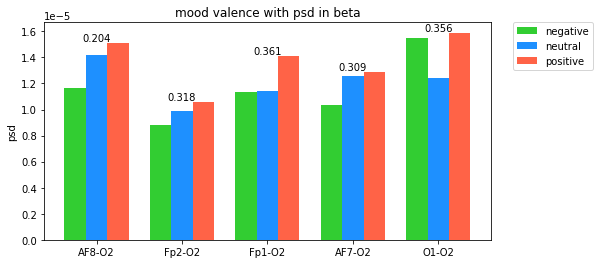

gamma
0.537 

0.323 

0.962 

0.642 

0.781 



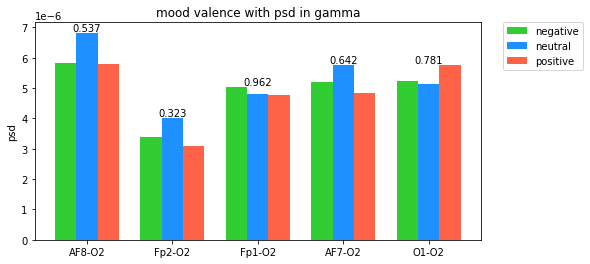

all
0.93 

0.421 

0.789 

0.966 

0.418 



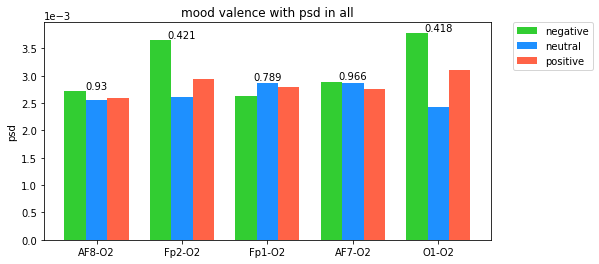

arousal
(107, 25)
(127, 25)
(85, 25)
theta
0.332 

0.642 

0.333 

0.199 

0.427 



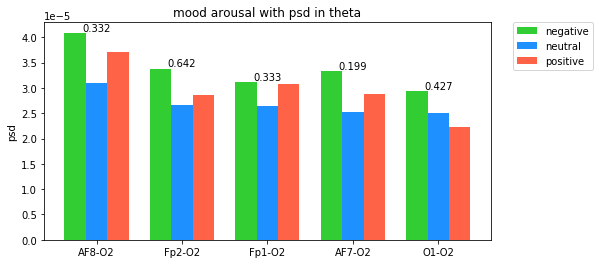

alpha
0.23 

0.456 

0.889 

0.462 

0.28 



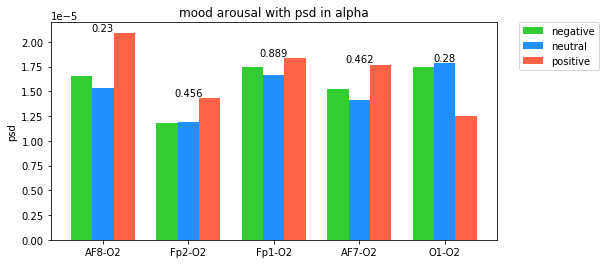

beta
0.763 

0.401 

0.993 

0.989 

0.102 



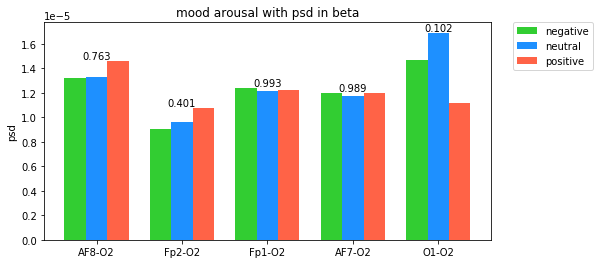

gamma
0.892 

0.924 

0.439 

0.782 

0.102 



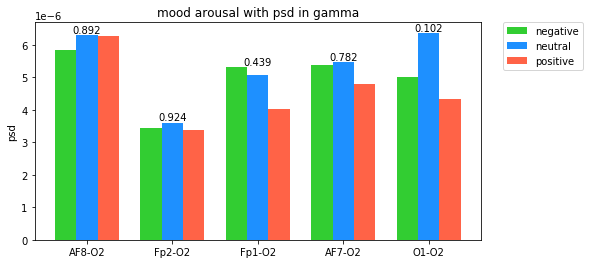

all
0.007 

0.014 

0.012 

0.003 

0.003 



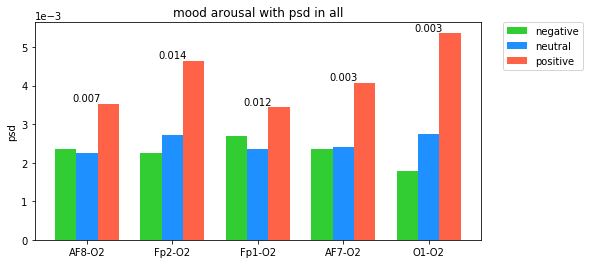

In [48]:
thres = [[0.49,0.58],[0.33,0.64]]
def mood_f():
    title = ['valence', 'arousal']
    for o in range(2):
        print(title[o])
        
        list_ne = []
        list_nu = []
        list_po = []
        for path in list(mood[title[o]].keys()):
            if mood[title[o]][path] < thres[o][0]:
                list_ne.append(psd[path])
            elif mood[title[o]][path] < thres[o][1]:
                list_nu.append(psd[path])
            else:
                list_po.append(psd[path])
        data_ne = np.array(list_ne)
        print(data_ne.shape)
        data_nu = np.array(list_nu)
        print(data_nu.shape)
        data_po = np.array(list_po)
        print(data_po.shape)
        
        label_name = ['theta', 'alpha', 'beta', 'gamma', 'all']
        
        width = 0.25  # 柱子的宽度
        for i in range(5):
            channel = ['AF8-O2', 'Fp2-O2', 'Fp1-O2', 'AF7-O2', 'O1-O2']
            x = np.arange(len(channel))  # x轴刻度标签位置
            plt.figure(figsize=(8, 4))
            print(label_name[i])

            avg_po=[]
            avg_nu=[]
            avg_ne=[]
            text=[]

            for j in range(5):
                avg_po.append(np.mean(data_po[:, i+j*5]))
                avg_nu.append(np.mean(data_nu[:, i+j*5]))
                avg_ne.append(np.mean(data_ne[:, i+j*5]))
                pvalue = str(round(f_oneway(data_po[:, i+j*5],data_nu[:, i+j*5], data_ne[:, i+j*5]).pvalue, 3))
                text.append(pvalue)
                print(pvalue, '\n')

            plt.bar(x - width, avg_ne, width, label='negative', color='limegreen')
            plt.bar(x, avg_nu, width, label='neutral', color='dodgerblue')
            plt.bar(x + width, avg_po, width, label='positive', color='tomato')

            y=np.zeros((5))
            for j in range(5):
                y[j]=avg_po[j]
                if avg_nu[j]>y[j]:
                    y[j]=avg_nu[j]
                if avg_ne[j]>y[j]:
                    y[j]=avg_ne[j]

            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

            plt.text(x[0], y[0], text[0], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
            plt.text(x[1], y[1], text[1], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
            plt.text(x[2], y[2], text[2], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
            plt.text(x[3], y[3], text[3], fontsize=10, verticalalignment="bottom", horizontalalignment="center")
            plt.text(x[4], y[4], text[4], fontsize=10, verticalalignment="bottom", horizontalalignment="center")

            plt.ylabel('psd')
            plt.title('mood ' + title[o] + ' with psd in ' + label_name[i])
            plt.xticks(x, channel)
            plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

            plt.savefig('EEG_analysis/mood_' + title[o] + '_mean' + label_name[i] + '.png')
            plt.show()

mood_f()